# Определение возраста покупателей

<a id=0></a>
[Содержание](#0)

[1. Описание проекта](#1)

[2. Анализ данных](#2)

[3. Обучение модели](#3)

[4. Общий вывод](#4)

<a id=1></a>
## 1. Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:**

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


**Данные:**

Данные взяты с сайта ChaLearn Looking at People:

http://chalearnlap.cvc.uab.es/dataset/26/description/

Они находятся в папке:

`/datasets/faces/`

Папка со всеми изображениями:

`/final_files/`

CSV-файл `labels.csv` с двумя колонками:
- `file_name`
- `real_age` 

Данные из папки извлекаем методом `ImageDataGenerator — flow_from_dataframe(dataframe, directory, ...)`.

**План работы:**

1. Загрузить данные и провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайте её качество.
4. Сделать вывод.

<a id=2></a>
[Содержание](#0)
## 2. Анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

RND_STATE = 24042023

Загрузим из файла данные по меткам:

In [12]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
    DIR = '/datasets/faces/final_files/'
except:
    labels = pd.read_csv('/Users/ed/Downloads/labels.csv')
    DIR = '/Users/ed/Downloads/final_files/'

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [13]:
display(labels.head(5))
display(labels.describe())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Построим график распределения возраста в выборке:

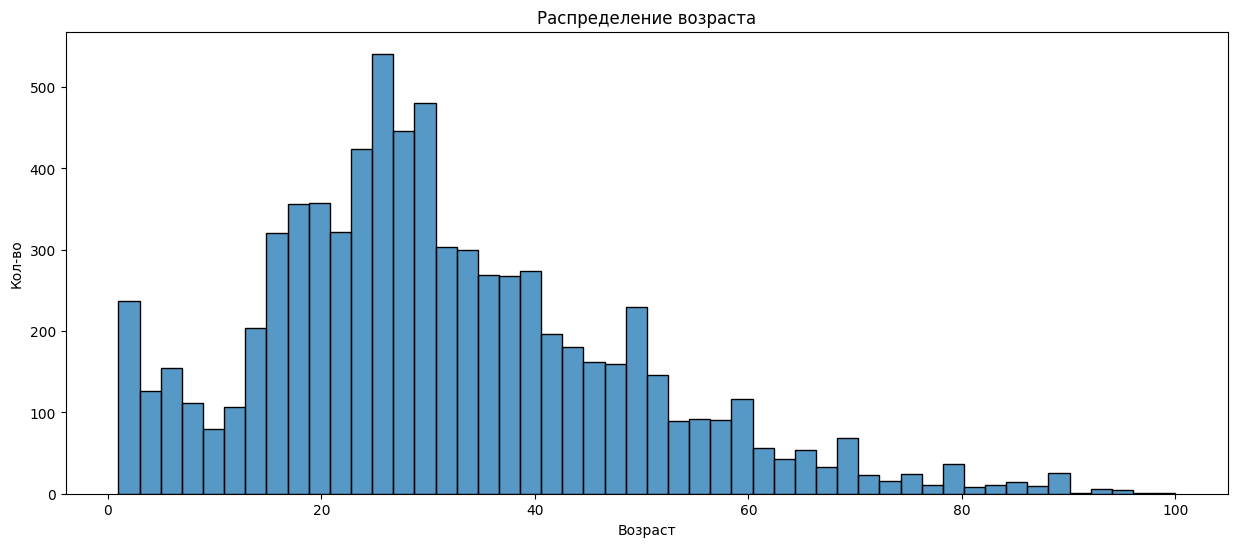

In [14]:
plt.figure(figsize = (15, 6))
sns.histplot(labels['real_age'], bins = 50)

plt.xlabel('Возраст')
plt.ylabel('Кол-во')
plt.title('Распределение возраста')
plt.show()

**Вывод:**

Датасет состоит из 7591 фотографий.

Разметка фотографий в файле `labels.csv`, содержащего две колонки `file_name` и `real_age`.

Больше всего фотографий в диапазоне от 17 до 41 года.

Также в выборке размечены дети и старики.

Для оценки возраста выборка небольшая.

Загрузим изображения из каталога потоком по 32 шт:

In [15]:
train_gen = ImageDataGenerator(rescale = 1./255)
train_source = train_gen.flow_from_dataframe(
        dataframe = labels,
        directory = DIR,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed = RND_STATE) 

Found 7591 validated image filenames.


Выведем 15 изображений, возраст укажем в названии каждого фото:

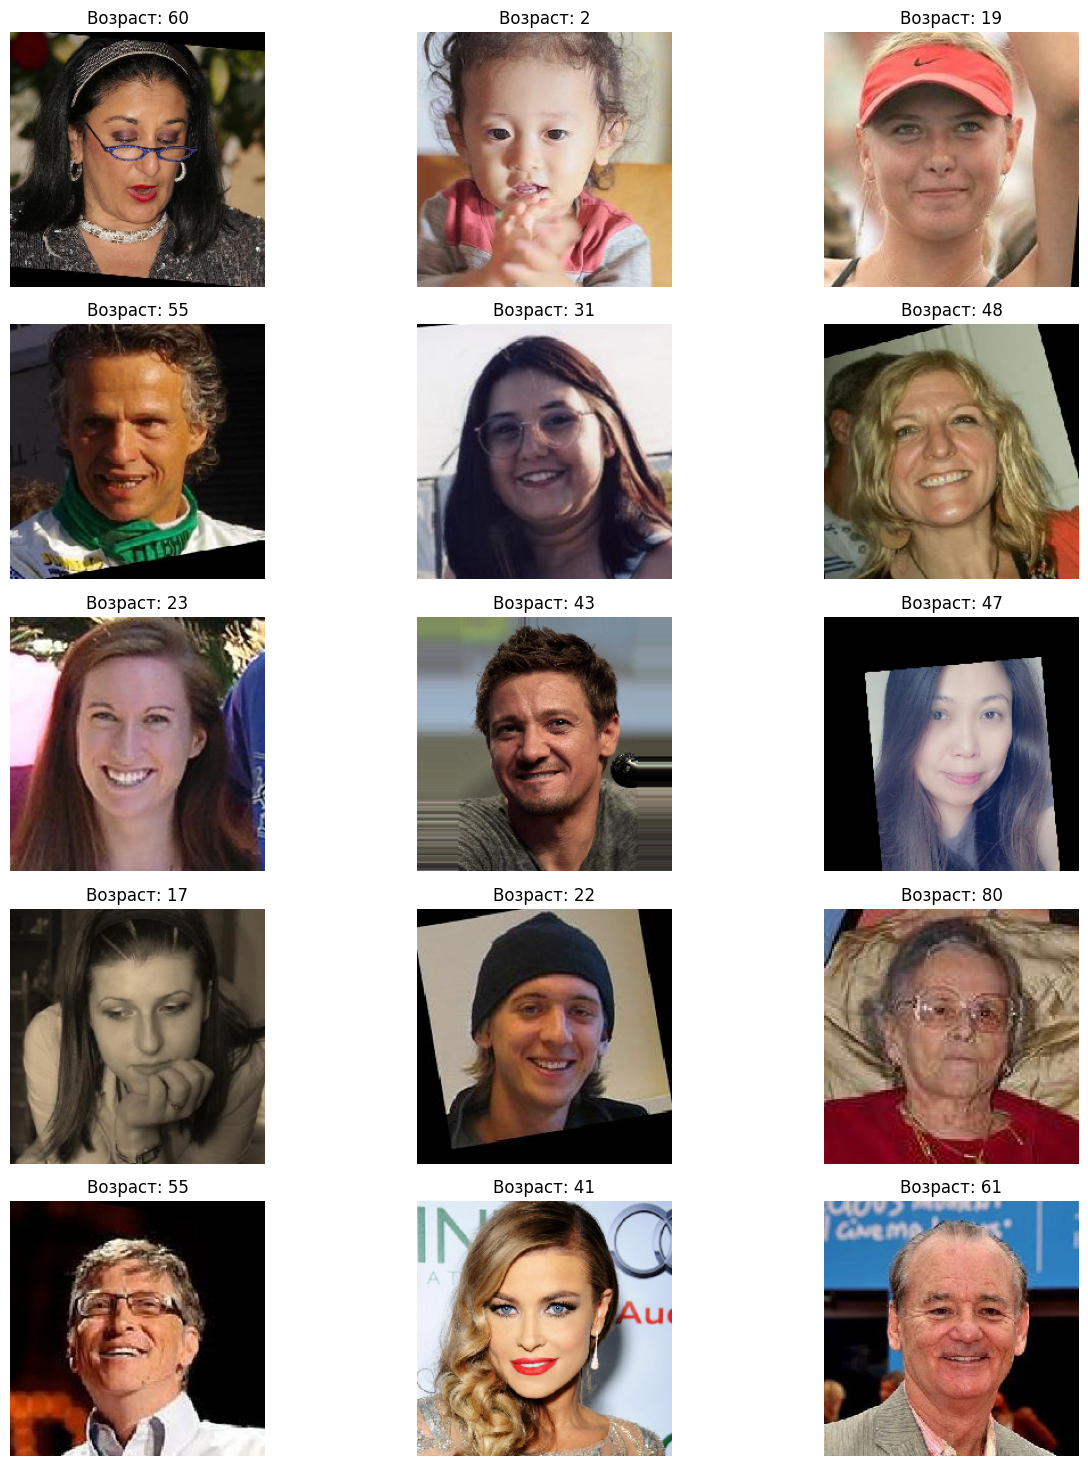

In [16]:
features, target = next(train_source)

fig = plt.figure(figsize = (15, 15))
for i in range(15):
    fig.add_subplot(5, 3, i + 1)
    plt.title('Возраст: ' + str(target[i]))
    plt.imshow(features[i])
    plt.tight_layout()
    plt.axis('off')

plt.show()

На фотографиях присутствуют объекты, которые закрывают лицо: очки, головной убор, рука, засвет на фото и т.д.

С учетом вложенных фотографий модели будет непросто оценивать возраст.

**Вывод**

В результате выполнения задач этого раздела было выявлено:

- Для определения возраста человека по фотографии нужно решить задачу регрессии, т.к. нам необходимо сравнить прогноз и верный ответ: чем дальше предсказание от реального ответа, тем оно хуже.
- График показал неравномерное распределение количества человек в зависимости от возраста в выборке, что может давать перекосы при обучении модели.
- В качестве ответа модель должна выдавать одно число - количество лет. Т.е. нужен всего один нейрон, который вернёт число-предсказание.
- В выходном слое сети должен остаться только один нейрон, выберем в качестве функции активации - ReLU. Положительные прогнозы сети функция ReLU не меняет, а все отрицательные — приводит к нулю. Чисел меньше 0 быть не может.
- Для задачи регрессии в качестве функции потерь выберем MAE.
- Общая ориентация фотографий вертикальная, а значит поворачивать их не нужно.
- Фотографии - цветные.
- Размер изображений не различается.

Данные загружены и подготовлены для модели.


<a id=3></a>
[Содержание](#0)
## 3. Обучение модели

Код обучения модели запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке:

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):

    labels = pd.read_csv(path + '/labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1./255,
        horizontal_flip = True)

    train_data = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files/',  
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 24042023)
 
    return train_data


def load_test(path):

    labels = pd.read_csv(path + '/labels.csv') 

    test_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1./255)

    test_data = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16, 
        class_mode = 'raw', 
        subset = 'validation',
        seed = 24042023)

    return test_data


def create_model(input_shape):

    optimizer = Adam(learning_rate = 0.00005)

    model = Sequential()

    backbone = ResNet50(input_shape = input_shape,
                weights = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                include_top = False)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 1, activation = 'relu'))

    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

    return model



def train_model(model, train_data, test_data, batch_size = None, epochs = 10,
                steps_per_epoch = None, validation_steps = None):

    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size,
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2,
              shuffle = True)

    return model
```

Результат вывода на экран, при обучении модели:

```
...
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-04-23 15:52:13.920305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-23 15:52:14.292996: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 65s - loss: 239.5643 - mae: 11.1992 - val_loss: 896.7526 - val_mae: 25.1047
Epoch 2/10
356/356 - 45s - loss: 81.0802 - mae: 6.8349 - val_loss: 133.8218 - val_mae: 8.8364
Epoch 3/10
356/356 - 42s - loss: 54.4500 - mae: 5.6367 - val_loss: 77.9037 - val_mae: 6.7470
Epoch 4/10
356/356 - 55s - loss: 38.9477 - mae: 4.7702 - val_loss: 85.1722 - val_mae: 7.0937
Epoch 5/10
356/356 - 57s - loss: 29.0773 - mae: 4.1485 - val_loss: 90.0287 - val_mae: 7.1246
Epoch 6/10
356/356 - 51s - loss: 23.6851 - mae: 3.6874 - val_loss: 106.8431 - val_mae: 8.0620
Epoch 7/10
356/356 - 46s - loss: 20.2638 - mae: 3.4324 - val_loss: 68.5779 - val_mae: 6.3010
Epoch 8/10
356/356 - 55s - loss: 16.4824 - mae: 3.1033 - val_loss: 67.0104 - val_mae: 6.1343
Epoch 9/10
356/356 - 55s - loss: 13.6576 - mae: 2.8077 - val_loss: 63.5975 - val_mae: 5.9409
Epoch 10/10
356/356 - 43s - loss: 12.0252 - mae: 2.6421 - val_loss: 67.0271 - val_mae: 6.2173
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 67.0271 - mae: 6.2173
Test MAE: 6.2173
```

**Вывод:**

В этом разделе была построена и обучена свёрточная нейронная сеть на датасете с фотографиями людей.

В результате выполнения задач этого раздела было выявлено:

- За 10 эпох обучения удалось уменьшить MAE с 11 до 2.6 на тренировочной выборке, дальнейшее обучение возможно улучшит результат.
- Для оценки возраста выборка небольшая, по этому модель немного переобучена, по этому на тестовой выборке MAE равно 6.217.
- Значение MAE на тестовой выборке равно 6.217, что выполняет условие изначально поставленной задачи.

<a id=4></a>
[Содержание](#0)
## 4. Общий вывод

Построена модель, которая определяет приблизительный возраст человека по фотографии.

Входные данные - датасет из 7591 фотографий людей с указанием возраста.

В результате исследования удалось получить значение *MAE = 6.217* на тестовой выборке, что выполняет условие поставленной задачи.

Результаты исследования позволят определять возраст клиентов в прикассовой зоне сетевого супермаркета «Хлеб-Соль»,
чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы

Однако полученная метрика MAE, которая показывает среднюю абсолютную разницу между прогнозируемыми значениями и фактическими значениями в наборе данных, а именно в возрасте покупателей, не позволяет рекомендовать использовать модель,
чтобы:

- Контролировать добросовестность кассиров при продаже алкоголя


**Рекомендации:**

Сетевому супермаркету «Хлеб-Соль» можно рекомендовать использовать полученную модель как систему компьютерного зрения для обработки фотографий покупателей для, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы

Для решения задачи контроля добросовестности кассиров при продаже алкоголя и для увеличения точности работы модели можно применить следующие методы:
- увеличить кол-во фотографий в обучающей выборке;
- использовать операции преобразования изображений (горизонтальное/вертикальное отражение, смещение, вращение);
- добавить больше слоев в модель, исползовать модель с другой структурой слоев;
- увеличить размеры обучающих фотографий (используемый размер 224х224 уже большой размер);
- увеличить кол-во эпох обучения;
- уменьшить кол-во каналов.
